In [1]:
%matplotlib inline


<center>
<h1>Sensitivity analysis and optimization with dolfin-adjoint</h1>
<br/>
<img src='da-logo.png' alt='Scaling test'  width='200'>

<br/>
<h3>Simon Funke</h3>
<h4>Slides: https://goo.gl/W8J51i</h4>
<br/>
13th October 2016, UNISA Symposium
<br/>
<br/>
Contributors: Patrick Farrell, Marie Rognes
</center>

## Sensitivity analysis


**Given:** 

* A PDE with some parameter(s).

* A (scalar) output derived from the solution.

**Goal:**

* Compute the sensitivity of the outout with respect to the parameters.

## Why adjoints are useful

The solution of the adjoint PDE allows us to evaluate the sensitivity with **arbitrary** parameters

-- at a **fixed cost**!

## In maths

**Given:** 

* PDE $F(u; m) = 0$ with solution $u$ and parameter $m$.

* A functional $J(u, m)$

**What the adjoint approach gives us:**

* Efficiently compute $\frac{\text{d}J}{\text{dm}}$ for any $m$.

## What is an adjoint 

Given a PDE and a functional, the adjoint is 

* a linear PDE derived from the original ("forward) system.
* which depends on the forward solution u and the functional J,
* that in general is quite hard to derive
* and is useful for lots of things in computational science.

## Adjoints are used in many applications

<center>
<img src='conceptmap-greyed.svg'  width='1024'>
</center>

## The problem

*[T]he automatic generation of optimal (in terms of robustness and efficiency) adjoint versions of large-scale simulation code is one of the great open challenges in the field of High-Performance Scientific Computing.*

"The Art of Differentiating Computer Programs", Naumann (2011)


*Considering the importance of design to .. all of engineering, it is
perhaps surprising that the development of adjoint codes has not
been more rapid .. [I]t seems likely that part of the reason is its
complexity.*

"An Introduction to the Adjoint Approach to Design" (Giles and Pierce, 2000)

## The traditional way of computing adjoints

<center>
<img src='ad_old.png'  width='800'>
</center>

### Fundamental idea

A model is a sequence of elementary instructions. Differentiate each in turn, and
compose with the chain rule.

## The dolfin-adjoint approach

<center>
<img src='ad_new.png'  width='800'>
</center>

### Fundamental idea
A model is a sequence of equation solves. Differentiate each in turn, and
compose with the chain rule. 

# dolfin-adjoint automates adjoints and PDE-constrained optimization*

<center>
<img src='da1.png'  width='1024'>
</center>

*for FEniCS models

## dolfin-adjoint annotates the symbolic equation of the PDE constraint
<center>
<img src='da2.png'  width='1024'>
</center>

## dolfin-adjoint automatically derives the symbolic adjoint equations
<center>
<img src='da3.png'  width='1024'>
</center>

## dolfin-adjoint solves forward/adjoint problems until the optimal solution is found
<center>
<img src='da4.png'  width='1024'>
</center>

## Advantages of the dolfin-adjoint approach

* The adjoint derivation is **totally automatic** (∼3–10 lines)
* The adjoint is **very efficient** (examples later)
* The adjoint can automatically use **checkpointing**
* The adjoint works **naturally in parallel** (both MPI and OpenMP)

Why does it run in parallel?

## The FEniCS pipeline is employed both for the forward and the adjoint problem 
<center>
<img src='parallel_adjoint.png'  width='800'>
</center>

# Live demo

## Imagine with given have a FEniCS solver

It does not really matter which one. For example a heat-equation solver:

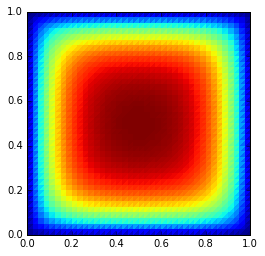

In [7]:
from dolfin import *
from dolfin_adjoint import *
#adj_reset()

mesh = UnitSquareMesh(40, 40)
V = FunctionSpace(mesh, "CG", 2)

v = TestFunction(V)# Testfunction 
u_ = Function(V)   # Old u
u = Function(V)    # New u
f = Function(V)    # Forcing term
f.vector()[:] = 1
nu = Function(V)   # Viscosity
nu.vector()[:] = 0.001

t = 0.0
end = 20
timestep = Constant(1)

# Variational form
F = (u - u_)/timestep*v*dx + nu*inner(grad(u), grad(v))*dx - f*v*dx
bc = DirichletBC(V, 0.0, "on_boundary")

# Time loop
while (t <= end):
    solve(F == 0, u, bc)
    u_.assign(u)
    t += float(timestep)
plot(u)

## In order to use dolfin-adjoint, we need to make change one line

On the second line:
```python
from dolfin_adjoint import *
```
With that change, dolfin-adjoint will record all equations that are being solved.

Now we can compute the define the functional. Let's say we are interested in:

$J = \frac{1}{2}\int_\Omega u(T) \cdot u(T) \textrm{d}x +\frac{1}{2}\int_\Omega f^2 \textrm{d}x$ 

In code:

In [11]:
J = Functional(u*u*dx*dt[FINISH_TIME] + f**2*dx*dt[START_TIME])

## Now we can compute sensitivities

For example with respect to $f$:

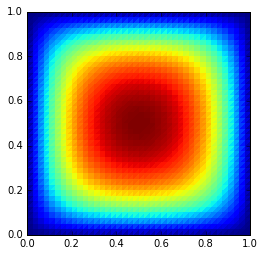

In [13]:
ctrl = Control(f)

dJdf = compute_gradient(J, ctrl, forget=False, project=True)
plot(dJdf)

## or with respect to more parameters

(at nearly no additional cost)

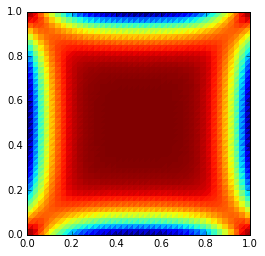

In [14]:
ctrl = [Control(f), Control(nu)]

dJdf, dJdnu = compute_gradient(J, ctrl, forget=False, project=True)
plot(dJdnu)

## Or even solve an optimisation problem!

Calling FFC just-in-time (JIT) compiler, this may take some time.


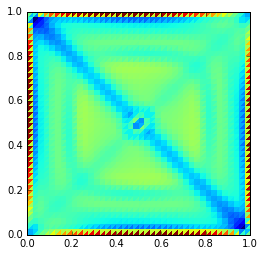

In [15]:
rf = ReducedFunctional(J, Control(nu))
nu_opt = minimize(rf, options={"maxiter": 4})
plot(nu_opt)

## Some important dolfin-adjoint functions


### Functionals
*Mathematics*: 

$J = \frac{1}{2}\int_\Omega u(T) \cdot u(T) \textrm{d}x$

*Code*:
```python 
J = Functional(0.5*inner(u, u)*dx*dt[FINISH TIME])
```

*Mathematics*:  

$J = \frac{1}{2}\int_0^T\int_\Omega u \cdot u \textrm{d}x\text{d}t$

*Code*:
```python 
J = Functional(0.5*inner(u, u)*dx*dt)
```

## Some important dolfin-adjoint functions


### Controls
```python
ctrl = Control(f)
ctrl = [Control(f), Control(g)]
```

### Compute sensitivity
```python
dJdf = compute_gradient(J, ctrl)
H = compute_hessian(J, ctrl)
```

### Solve optimization problem
```python
rf = ReducedFunctional(J, ctrl)
f_opt = minimize(rf)
```

# Some application examples

## Cahn-Hilliard equations

<center>
<img src='cahn.png'  width='600'>
</center>

Quite a difficult problem to adjoint:
* nonlinear, time-dependent, fourth-order equation
* run in parallel (8 processors, MPI)
* checkpointing necessary (5 in memory, 10 on disk)

## Willmore functional

\begin{align*}
W(u(t)) &= \frac{1}{4\epsilon} \int_{\Omega} \left(\epsilon \nabla^2 u(t=T) - \frac{1}{\epsilon} \frac{df}{dc}\right)^2 \ {dx}
\end{align*}

## dolfin-adjoint computes the gradient efficiently

<center>
<img src='cahn_timings.png'  width='1024'>
</center>

## Topology optimisation of a heat conduction problem

Problem: Find the material distribution that minimises the integral of the temperature when the amount of highly conducting material is limited.


<center>
<img src='heatsink.png'  width='1024'>
</center>

## Formulation as an optimisation problem


\begin{equation*}
min_{a} \int_{\Omega} fT + \alpha \int_{\Omega} \nabla a \cdot \nabla a
\end{equation*}

subject to

\begin{align*}
      -\mathrm{div}(k(a) \nabla T) &= f  \qquad \mathrm{in} \ \Omega           \\
                        T &= 0  \qquad \mathrm{on} \ \delta \Omega_D  \\
          (k(a) \nabla T) &= 0  \qquad \mathrm{on} \ \delta \Omega_N  \\
\end{align*}          

and to the control constraints

\begin{align*}
         0 \le a(x) &\le 1  \qquad \forall x \in \Omega \\
         \int_{\Omega} a &\le V
\end{align*}  
Implementation consists of 65 lines of code (including IO)

### 2D Solution
<center>
<img src='poisson-topology.png' alt='Scaling test'  width='600'>
</center>

### 3D Solution
<img src='poisson-topology-3d.png' alt='Scaling test'  width='1024'>

## OpenTidalFarm - Optimal tuning of tidal turbine farms

* Optimisation of number of turbines, their location and their size 
* Based on a shallow water solver in FEniCs + dolfin-adjoint

<center>
<img src='graphical_highlight_high_res.png' alt='Scaling test'  width='800'>
www.opentidalfarm.org
</center>

## CBC-beat - cardiac electriophiosology with an adjoint

* Implements the mono-domain and bi-domain solvers with various cell models (coupled PDE-ODE system)
* Implemented in FEniCS + Gortran (cell model generator for FEniCS) + dolfin-adjoint
<center>
<img src='cbcbeat.png' alt='Scaling test'  width='800'>
</center>

# Data assimilation of blood flow models

**Given MRI flow measurements, can we tune a blood flow model?**

* Implements Navier-Stokes in FEniCS + dolfin-adjoint
* Requires carefull design of regularisation terms
<center>
<img src='bloodflow.png' alt='Scaling test'  width='600'></center>

## Multimesh support in FEniCs (Outlook)
<center>
<img src='propeller_body_fitted.svg' alt='Scaling test'  width='600'>
</center>

## Multimesh support in FEniCs (Outlook)
<center>
<img src='multi_propeller_body_fitted.svg' alt='Scaling test'  width='600'>
</center>

## Multimesh support in FEniCs (Outlook)

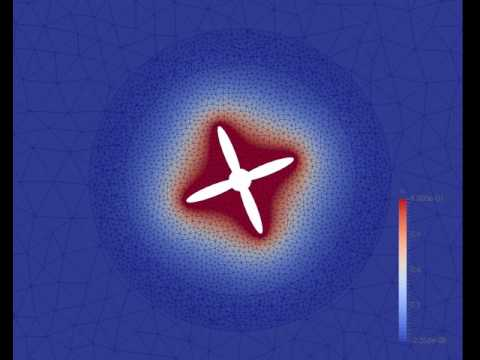

In [22]:
from IPython.display import YouTubeVideo
YouTubeVideo("wbdN0_9P6Hw")

## Computing sensitivities

Here, with respect to the initial condition:
<center>
<img src='turbine_dJdinit.jpg' alt='Scaling test'  width='800'>
</center>


## Conclusion


*dolfin-adjoint* automates adjoints for FEniCS models. 

You can use it for:
* Sensitivity analysis
* PDE-constrained optimisation
* Stability analysis
* ...

www.dolfin-adjoint.org
